# Notebook 4 - Preprocessing dataset #2: Predicting windfarm power output

On to the second dataset. Here the task is to predict the power output of a windfarm in Chile. The farm consists of over 20 turbines with a hub height of 80 meters. 

The data we have available are NWP forecasts from three different global models and observation data taken from withing the wind farm.

In this notebook, we will explore the data and prepare it for our machine learning models. This dataset requires a lot more work than our first post-processing dataset. Let's get started

In [120]:
import os
import xarray as xr
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import pickle

In [2]:
DATA_DIR = '/local/S.Rasp/ML-Workshop-Data/dataset2/'

In [3]:
os.listdir(DATA_DIR)

['ml_workshop_data.7z',
 'README.md',
 'metobs.nc',
 'nwp_ecmwf-ifs.nc',
 'nwp_envca-gdps.nc',
 'nwp_ncep-gfs4.nc',
 'windpark.nc',
 'forecast_errors.png',
 'power_curve_single_turbine.png']

## Exploratory data analysis (EDA)

First, let's understand the different files. The files are in netCDF format. We will use [xarray](http://xarray.pydata.org/en/stable/) to handle these files. xarray is designed to be the Pandas for multi-dimensional data.

xarray has two basic objects: Datasets and DataArrays. Datasets contain multiple variables (e.g. temperature, humidity, etc.) while DataArrays just contain one variables. Datasets therefore are a combination of multiple DataArrays.

### NWP Data

These three files contain global NWP forecast from three models: ECMWF, Environment Canada and NCEP.



In [4]:
# Open all three
nwp_ec = xr.open_dataset(DATA_DIR + 'nwp_ecmwf-ifs.nc')
nwp_en = xr.open_dataset(DATA_DIR + 'nwp_envca-gdps.nc')
nwp_nc = xr.open_dataset(DATA_DIR + 'nwp_ncep-gfs4.nc')

In [5]:
nwps = {'ec': nwp_ec, 'en': nwp_en, 'nc': nwp_nc}

In [8]:
# Here we can see the information inside a dataset. 
nwps.items()

dict_items([('ec', <xarray.Dataset>
Dimensions:   (epoch_s: 1463, offset_s: 49)
Coordinates:
  * epoch_s   (epoch_s) int32 1420070400 1420113600 1420156800 1420200000 ...
  * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
Data variables:
    ws100m    (epoch_s, offset_s) float32 ...
    wd100m    (epoch_s, offset_s) float32 ...
    ws10m     (epoch_s, offset_s) float32 ...
    wd10m     (epoch_s, offset_s) float32 ...
    t2m       (epoch_s, offset_s) float32 ...
    blh       (epoch_s, offset_s) float32 ...), ('en', <xarray.Dataset>
Dimensions:   (epoch_s: 1463, offset_s: 49)
Coordinates:
  * epoch_s   (epoch_s) int32 1420070400 1420113600 1420156800 1420200000 ...
  * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
Data variables:
    ws1000mb  (epoch_s, offset_s) float32 ...
    wd1000mb  (epoch_s, offset_s) float32 ...
    ws925mb   (epoch_s, offset_s) float32 ...
    wd925mb   (epoch_s, offset_s) float32 ...
    tclcov    (epo

Datasets have dimensions, each of which comes with a coordinate array, specifying for example the longitude. Datasets also have one or more data variables. 

Note that xarray does not actually load the data into memory, but only the meta-information. The actual data will only be loaded, if we use or access it directly.

In [10]:
nwps['ec'].ws100m

<xarray.DataArray 'ws100m' (epoch_s: 1463, offset_s: 49)>
array([[5.862752, 6.489872, 5.634605, ..., 3.723847, 3.393842, 3.08379 ],
       [4.399415, 6.428493, 6.897442, ..., 1.98581 , 1.536039, 1.566706],
       [6.382539, 3.919209, 3.203686, ..., 4.056922, 2.816343, 1.857518],
       ...,
       [4.498196, 4.457619, 4.138986, ..., 6.241402, 7.019463, 7.035955],
       [3.764302, 5.218565, 7.210479, ..., 2.672324, 3.532972, 6.649615],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
  * epoch_s   (epoch_s) int32 1420070400 1420113600 1420156800 1420200000 ...
  * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
Attributes:
    descr:    wind speed 100 m above surface
    units:    m/s

This is now a DataArray. As you can see it also has coordinates and dimensions, and additionally attributes such as units.

- `epoch_s` is the initialization time of the forecast as a POSIX timestamp (seconds after 1970-01-01 00:00)
- `offset_s` is the forecast lead time for a given forecast in seconds

POSIX timestamps might not be the most convenient to work with. So we will convert them to numpy datetime objects.

In [12]:
# Convert POSIX to datetime
for nwp in nwps.values():
    nwp['epoch_s'] = pd.to_datetime(nwp.epoch_s, unit='s')

In [14]:
nwps['ec'].epoch_s

<xarray.DataArray 'epoch_s' (epoch_s: 1463)>
array(['2015-01-01T00:00:00.000000000', '2015-01-01T12:00:00.000000000',
       '2015-01-02T00:00:00.000000000', ..., '2016-12-31T00:00:00.000000000',
       '2016-12-31T12:00:00.000000000', '2017-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * epoch_s  (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T12:00:00 ...

Now, we would like to know how much data is available for each NWP model.

In [16]:
ns2h = 1 / (1e9 * 60 * 60)
ns2min = 1 / (1e9 * 60)

In [19]:
for m, nwp in nwps.items():
    print(m, nwp.epoch_s.min(), nwp.epoch_s.max(), int(nwp.epoch_s[1] - nwp.epoch_s[0]) * ns2h)

ec <xarray.DataArray 'epoch_s' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'epoch_s' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]') 12.0
en <xarray.DataArray 'epoch_s' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'epoch_s' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]') 12.0
nc <xarray.DataArray 'epoch_s' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'epoch_s' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]') 6.0


Data is available for the years 2015 and 2016. Two models have forecasts in a 12 hour interval, the last model has a 6 hour interval.

In [21]:
for m, nwp in nwps.items():
    print(m, nwp.offset_s.max() / 60 / 60, (nwp.offset_s[1] - nwp.offset_s[0]) / 60 / 60)

ec <xarray.DataArray 'offset_s' ()>
array(144.) <xarray.DataArray 'offset_s' ()>
array(3.)
en <xarray.DataArray 'offset_s' ()>
array(144.) <xarray.DataArray 'offset_s' ()>
array(3.)
nc <xarray.DataArray 'offset_s' ()>
array(144.) <xarray.DataArray 'offset_s' ()>
array(3.)


All models have a maximum forecast lead time of 144 hours = 6 days and output in 3 hour intervals.

### Mast data

Quantities `ws80m` and `ws34m` are taken from a met mast located inside the wind farm. The other quantities are averages over all available nacelle anemometers, and as such may not be as accurate or quality controlled.

In [22]:
met = xr.open_dataset(DATA_DIR + 'metobs.nc'); met

<xarray.Dataset>
Dimensions:  (epoch_s: 63072)
Coordinates:
  * epoch_s  (epoch_s) int32 1420070400 1420071300 1420072200 1420073100 ...
Data variables:
    ws_avg   (epoch_s) float32 ...
    wd_avg   (epoch_s) float32 ...
    ws80m    (epoch_s) float32 ...
    ws34m    (epoch_s) float32 ...

In [23]:
# Convert to date time
met['epoch_s'] = pd.to_datetime(met.epoch_s, unit='s')

In [24]:
met.epoch_s.min(), met.epoch_s.max(), int(met.epoch_s[1] - met.epoch_s[0]) * ns2min

(<xarray.DataArray 'epoch_s' ()>
 array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array('2016-10-18T23:45:00.000000000', dtype='datetime64[ns]'),
 15.0)

Here we have data from the start of 2015 to 2016-10-18 in 15 minute intervals

### Wind power production data

Power production is normalized to the farm capacity and thus ranges from 0 to 1. The `rawpower` is what a met service provider would
usually receive as feed-in data from the neighboring power grid station. Here we have no information about turbine maintainance and
failures, as well as curtailment measures. In case of this farm however, we received status information and production info from all individual
turbines. In addition to taking these into account, we also applied a Gaussian Process based filtering procedure to remove additional outliers.
The result is compiled into `power`.

In [25]:
pwr = xr.open_dataset(DATA_DIR + 'windpark.nc'); pwr

<xarray.Dataset>
Dimensions:   (epoch_s: 94608)
Coordinates:
  * epoch_s   (epoch_s) int32 1420070400 1420071000 1420071600 1420072200 ...
Data variables:
    power     (epoch_s) float32 ...
    rawpower  (epoch_s) float32 ...

In [26]:
# Convert to date time
pwr['epoch_s'] = pd.to_datetime(pwr.epoch_s, unit='s')

In [27]:
pwr.epoch_s.min(), pwr.epoch_s.max(), int(pwr.epoch_s[1] - pwr.epoch_s[0]) * ns2min

(<xarray.DataArray 'epoch_s' ()>
 array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array('2016-10-18T23:50:00.000000000', dtype='datetime64[ns]'),
 10.0)

For our target data, we have the same time range, but output in 10 minute intervals

### Xarray indexing and plotting

Before we start manipulating the data, let's first have a look. This way we can also learn a lot about how cool xarray is.

**Indexing in xarray:** 
Next, we will look at how indexing, i.e. selecting parts of the data, works. There are two basic methods. Selecting by integers/index, similarly to what you would do in numpy and selecting by label.

To create a plot in xarray, simply type .plot() for a 2 or 3 dimensional dataarray.

In [28]:
nwps['ec'].ws100m

<xarray.DataArray 'ws100m' (epoch_s: 1463, offset_s: 49)>
array([[5.862752, 6.489872, 5.634605, ..., 3.723847, 3.393842, 3.08379 ],
       [4.399415, 6.428493, 6.897442, ..., 1.98581 , 1.536039, 1.566706],
       [6.382539, 3.919209, 3.203686, ..., 4.056922, 2.816343, 1.857518],
       ...,
       [4.498196, 4.457619, 4.138986, ..., 6.241402, 7.019463, 7.035955],
       [3.764302, 5.218565, 7.210479, ..., 2.672324, 3.532972, 6.649615],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
  * epoch_s   (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T12:00:00 ...
  * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
Attributes:
    descr:    wind speed 100 m above surface
    units:    m/s

In [29]:
# Select the the first 20 forecast time steps from the 20th forecast start time
# For this we use the index selector .isel()
nwps['ec'].ws100m.isel(epoch_s=20, offset_s=slice(0, 20))

<xarray.DataArray 'ws100m' (offset_s: 20)>
array([3.534174, 3.559642, 3.491649, 2.59831 , 1.64235 , 3.57182 , 3.769378,
       3.099703, 3.128359, 3.093469, 1.364475, 1.757233, 3.102271, 5.171213,
       3.935051, 4.156376, 5.268105, 4.300811, 3.862257, 3.054147],
      dtype=float32)
Coordinates:
    epoch_s   datetime64[ns] 2015-01-11
  * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
Attributes:
    descr:    wind speed 100 m above surface
    units:    m/s

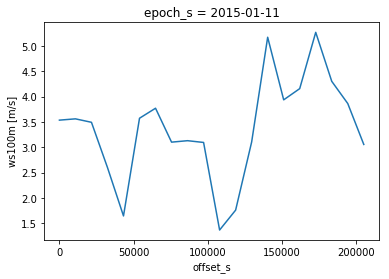

In [30]:
# Now to plot that
nwps['ec'].ws100m.isel(epoch_s=20, offset_s=slice(0, 20)).plot()

In [31]:
# Indexing by label using .sel()
# Select the forecast started at '2015-03-01'
nwps['ec'].ws100m.sel(epoch_s='2015-03-01')

<xarray.DataArray 'ws100m' (epoch_s: 2, offset_s: 49)>
array([[3.013495, 2.824081, 3.279218, 2.491317, 2.64834 , 4.400324, 5.96632 ,
        5.947004, 4.964555, 4.167326, 4.084863, 3.80739 , 3.922389, 3.500799,
        5.700959, 5.982351, 5.821174, 6.229479, 4.827539, 3.971917, 4.547969,
        4.449901, 5.645729, 6.245741, 5.787747, 5.071975, 4.860265, 4.045425,
        2.774431, 3.599641, 5.503121, 6.62407 , 5.599665, 5.714873, 5.308627,
        4.188989, 2.397828, 3.813381, 5.081452, 5.688699, 4.36575 , 4.669986,
        3.644226, 2.481066, 1.946111, 2.763823, 5.037122, 5.795748, 5.733331],
       [2.970057, 4.337174, 5.816758, 5.717138, 4.809617, 4.227816, 3.98024 ,
        3.618582, 3.634864, 3.597399, 6.056724, 5.874419, 5.984615, 6.0306  ,
        5.273086, 4.135433, 4.21349 , 4.668208, 5.755711, 6.162652, 5.678669,
        5.200613, 4.772378, 4.259148, 2.900473, 4.26903 , 6.12792 , 6.230092,
        6.351543, 5.909415, 5.368656, 4.024671, 2.706512, 3.712934, 4.859765,
        

In [32]:
# If the date chosen does not exactly match up, use nearest, ffill or bfill
nwps['ec'].ws100m.sel(epoch_s='2015-03-01T03')

KeyError: '2015-03-01T03'

In [33]:
nwps['ec'].ws100m.sel(epoch_s='2015-03-01T03', method='nearest')

<xarray.DataArray 'ws100m' (offset_s: 49)>
array([3.013495, 2.824081, 3.279218, 2.491317, 2.64834 , 4.400324, 5.96632 ,
       5.947004, 4.964555, 4.167326, 4.084863, 3.80739 , 3.922389, 3.500799,
       5.700959, 5.982351, 5.821174, 6.229479, 4.827539, 3.971917, 4.547969,
       4.449901, 5.645729, 6.245741, 5.787747, 5.071975, 4.860265, 4.045425,
       2.774431, 3.599641, 5.503121, 6.62407 , 5.599665, 5.714873, 5.308627,
       4.188989, 2.397828, 3.813381, 5.081452, 5.688699, 4.36575 , 4.669986,
       3.644226, 2.481066, 1.946111, 2.763823, 5.037122, 5.795748, 5.733331],
      dtype=float32)
Coordinates:
    epoch_s   datetime64[ns] 2015-03-01
  * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
Attributes:
    descr:    wind speed 100 m above surface
    units:    m/s

### Get some intuition of the data

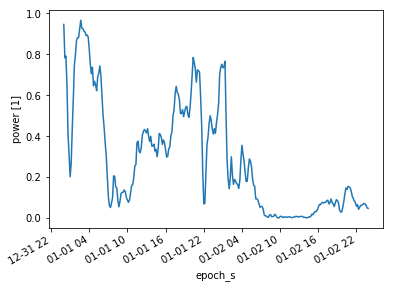

In [35]:
# Plot power output for two days
pwr.power.sel(epoch_s=slice('2015-01-01', '2015-01-02')).plot()

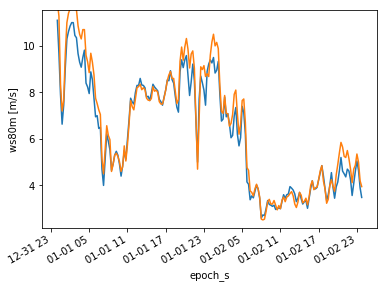

In [36]:
# And the corresponding wind speed
met.ws34m.sel(epoch_s=slice('2015-01-01', '2015-01-02')).plot()
met.ws80m.sel(epoch_s=slice('2015-01-01', '2015-01-02')).plot()

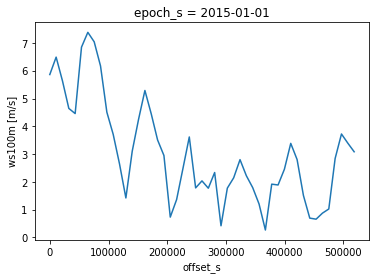

In [37]:
# And a corresponding model forecast
nwps['ec'].ws100m.sel(epoch_s='2015-01-01T00').plot()

### Wind farm power curve

The wind farm power curve is a standard diagnostic. It is the wind speed plotted against the power production.

In [51]:
# Since the wind speed measurements and power data have different output intervals
# we want to only chose the intersecting time values.
intersect = np.intersect1d(met.epoch_s, pwr.epoch_s)

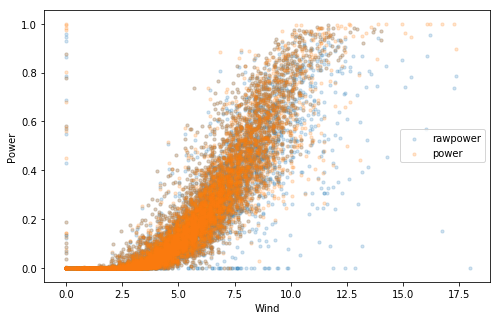

In [56]:
fig = plt.figure(figsize=(8, 5))
plt.scatter(met.ws34m.sel(epoch_s=intersect[::3]), pwr.rawpower.sel(epoch_s=intersect[::3]), s=10, alpha=0.2, 
           label='rawpower')
plt.scatter(met.ws34m.sel(epoch_s=intersect[::3]), pwr.power.sel(epoch_s=intersect[::3]), s=10, alpha=0.2,
           label='power')
plt.xlabel('Wind'); plt.ylabel('Power'); plt.legend();

**@MARTIN**

Wie sollte ich hier die Daten bereinigen? Ich wuerde die Outlier fuer Wind=0 & power>0 wegwerfen.

Sollten wir power oder rawpower benutzen?

### Cleaning the target dataset

Instead of predicting the power output every 10 minutes, let's predict the 3 hourly average instead.

In [56]:
pwr_3h = pwr.resample(epoch_s='3h').mean()

In [57]:
pwr_3h

<xarray.Dataset>
Dimensions:   (epoch_s: 5256)
Coordinates:
  * epoch_s   (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T03:00:00 ...
Data variables:
    power     (epoch_s) float64 0.688 0.7702 0.2083 0.179 0.3741 0.4256 ...
    rawpower  (epoch_s) float64 0.6888 0.7698 0.208 0.179 0.3739 0.4251 ...

## Prepare the data

Our goal is to produce a power forecast every three hours for a forecast time of 4 days in 3 hour intervals.

The test time range is from 2016-05-01 to 2016-10-18T23:50. 

It is up to us to chose the validation dataset. For now, let's simply chose the last 4 month of the data available to us. We can rethink later whether this is the best choice.

In [38]:
train_range = slice('2015-01-01', '2015-12-31')
valid_range = slice('2016-01-01', '2016-04-30')
test_range = slice('2016-05-01', '2016-10-18T23:50')

In [42]:
fc_lead = np.timedelta64(4*24, 'h')

In [43]:
every_3_hours = np.arange('2015-01-01', np.datetime64('2016-10-18T23:50')-fc_lead, 
                          np.timedelta64(3, 'h'), dtype='datetime64[ns]')

Let's now write a few functions to grab the correct time slice for each of the different data types.

In [129]:
def get_y(t, da=pwr_3h.rawpower, dt=np.timedelta64(3, 'h')):
    """Returns the values of da from time t to time t+fc_lead in dt intervals."""
    time_idxs = np.arange(t, t+fc_lead, dt, dtype='datetime64[ns]')
    return da.sel(epoch_s=time_idxs).values

In [97]:
nwps['ec'].data_vars

Data variables:
    ws100m   (epoch_s, offset_s) float32 5.862752 6.4898725 5.634605 ...
    wd100m   (epoch_s, offset_s) float32 357.8887 355.0636 352.50848 ...
    ws10m    (epoch_s, offset_s) float32 4.3632684 4.9153886 3.9240022 ...
    wd10m    (epoch_s, offset_s) float32 1.5649021 357.9336 357.52618 ...
    t2m      (epoch_s, offset_s) float32 289.7251 287.78174 286.77124 ...
    blh      (epoch_s, offset_s) float32 360.35876 355.90982 263.80725 ...

In [99]:
def get_latest_fc(t, fields={'ec': nwps['ec'].data_vars}, flatten=True):
    """
    Returns the NWP forecast fields of the most recent initialization time. 
    The first forecast lead time corresponds to t, going up to t+fc_lead.
    All fields are concatenated at the end to a 1D vector, if flatten=True.
    """
    a = []
    for nwp, fs in fields.items():
        e = nwps[nwp].sel(epoch_s=t, method='ffill')
        offset = int(t - e.epoch_s) / 1e9
        e = e.sel(offset_s=slice(offset, offset+fc_lead.astype('timedelta64[s]').astype('int')))
        for f in fs:
            a.append(e[f].values)
    a = np.array(a)
    return a.reshape(-1) if flatten else a

In [100]:
def get_met_obs(t, da, t_back=np.timedelta64(6, 'h'), dt=np.timedelta64(30, 'm')):
    """Returns the values of da from time t-t_back up to excluding t in increments ot dt."""
    time_idxs = np.arange(t-t_back, t, dt, dtype='datetime64[ns]')
    return da.sel(epoch_s=time_idxs).values

With these functions we can now create our training and validation set. For starters, let's simply use all ECMWF fields as features.

In [115]:
def get_Xy(tstart, tstop, istest=False):
    X, y = [], []
    for t in tqdm(every_3_hours[(every_3_hours >= np.datetime64(tstart)) & 
                                (every_3_hours <= np.datetime64(tstop))]):
        X.append(get_latest_fc(t))
        if not istest: y.append(get_y(t))
    return (np.array(X), np.array(y)) if not istest else np.array(X)

In [130]:
X_train, y_train = get_Xy(train_range.start, train_range.stop)

In [131]:
X_valid, y_valid = get_Xy(valid_range.start, valid_range.stop)

In [132]:
X_test = get_Xy(test_range.start, test_range.stop, istest=True)

In [133]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape

((2913, 198), (2913, 32), (961, 198), (961, 32), (1336, 198))

In [134]:
with open('./data/wind_ds.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_valid, y_valid, X_test), f)

## Create a first prediction

Let's get a reference score with mean predictions.

In [122]:
def mse(y_true, y_pred, axis=(0,1)): return ((y_true - y_pred)**2).mean(axis)

In [136]:
mse(y_valid, np.mean(y_train))

0.04141881267383446

In [137]:
from sklearn.metrics import r2_score

In [142]:
r2_score(y_valid, np.ones(y_valid.shape) * np.mean(y_train))

-0.0945540342416856

## Your turn

So far we have only used the ECMWF data for X. This might not be so great. Here are some challenged to include more data.

- Also use the data from the other weather centers. If you do, check the data. Could there be missing values? What do you do about them?
- Using the wind mast data just before the forecast could be really helpful. Include this. Again, do you have to deal with missing values?